In [126]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, meg_from_spikes
from nengo_learn_assoc_mem.utils import BasicVecFeed
from nengo_learn_assoc_mem.learning_rules.rec_adapt import RecAdapt

from collections import namedtuple
import random

In [43]:
dt = 0.001

In [61]:
dimensions = 32
n_neurons = 1500
seed = 6
n_items = 16
p_n = 0.1

In [62]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, \
foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [63]:
fan_vecs = np.concatenate((fan1_pair_vecs, fan2_pair_vecs))

In [64]:
simi = np.dot(fan_vecs, fan_vecs.T)
np.fill_diagonal(simi, 0)
max_simi = np.max(simi)
max_simi

0.67835443397694828

# Train Voja

In [76]:
t_present = 0.2
t_pause = 0.05
t_each = t_present + t_pause
n_repeats = 10

voja_learn_rate = 1e-6

In [77]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
random.shuffle(feed_vecs)

In [78]:
intercepts = 0.1*np.ones(n_neurons)
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    learning = nengo.Node(lambda t: -feed.paused)
    
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, neuron_type=nengo.LIF())

    in_conn = nengo.Connection(in_nd, ens, learning_rule_type=nengo.Voja(voja_learn_rate), synapse=None)
    nengo.Connection(learning, in_conn.learning_rule, synapse=None)

    p_enc = nengo.Probe(ens, 'scaled_encoders', sample_every=0.05)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:03.                                                                                
Simulating finished in 0:01:30.                                                                              


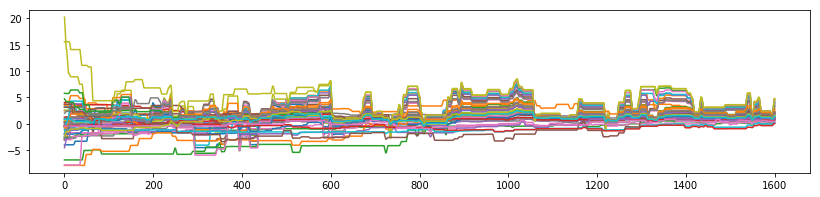

In [79]:
plt.figure(figsize=(14, 3))
plt.plot(sim.data[p_enc][:, :50, 0]);

In [80]:
enc = sim.data[p_enc][-1].copy()

## Double-check functionality

In [81]:
t_present = 0.3
t_pause = 0.1
t_each = t_present + t_pause

In [82]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [98]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, encoders=enc, neuron_type=nengo.LIF())

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens, output, learning_rule_type=nengo.PES(1e-3))
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] > 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(2*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                                                
Simulating finished in 0:01:08.                                                                              


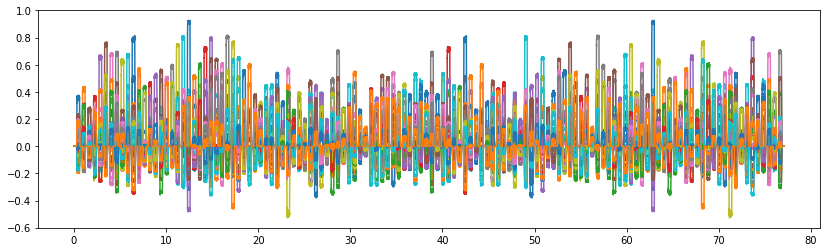

In [99]:
plt.figure(figsize=(14, 4))
plt.plot(learned_sim.trange(), spa.similarity(learned_sim.data[p_out], fan_vecs));
#plt.legend(fan_labels, loc=(1, 0));

In [100]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 2500)

In [102]:
t_present = 0.1
t_pause = 0.05
t_each = t_present + t_pause

In [109]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [107]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, encoders=enc, neuron_type=nengo.LIF())

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                                                
Simulating finished in 0:00:05.                                                                              


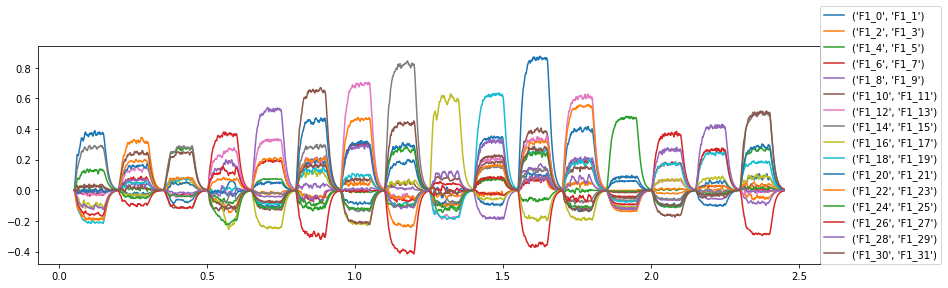

In [112]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange()[fan1_slc], spa.similarity(sim.data[p_out][fan1_slc], fan1_pair_vecs));
plt.legend(fan1, loc=(1, 0));

## Modify recurrence analytically

In [113]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [114]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, encoders=enc, neuron_type=nengo.LIF())

with nengo.Simulator(model) as sim:
    pass

Building finished in 0:00:02.                                                                                


In [115]:
_, activities = tuning_curves(ens, sim, inputs=np.array(feed_vecs))

In [155]:
norm_acts = np.zeros_like(activities)

In [156]:
norm_acts.shape

(32, 2500)

In [159]:
for v_i in range(activities.shape[0]):
    norm_acts = activities[v_i] / np.mean(activities[v_i])

In [160]:
norm_tot = np.sum(norm_acts, axis=0)

In [116]:
act_tot = np.sum(activities, axis=0)

In [161]:
max_inhib = -1e-2
norm_rec_w = np.interp(norm_tot,
                  (np.min(norm_tot), np.max(norm_tot)), (max_inhib, 0))

In [146]:
max_inhib = -1
rec_w = np.interp(act_tot,
                  (np.min(act_tot), np.max(act_tot)), (max_inhib, 0))

In [147]:
t_present = 0.3
t_pause = 0.3
t_each = t_present + t_pause

rec_synapse = 0.01

In [119]:
fan1_slc = slice(int(t_pause/dt), int(t_each/dt)*len(fan1_pair_vecs)+int(t_pause/dt))
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+int(t_each/dt)*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+int(t_each/dt)*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+int(t_each/dt)*len(foil2_pair_vecs))

In [120]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, fan1_slc),
                 "fan2": SlcStim(2, True, fan2_slc),
                 "foil1": SlcStim(1, False, foil1_slc),
                 "foil2": SlcStim(2, False, foil2_slc)}

In [121]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [138]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as base_model:
    in_nd = nengo.Node(feed.feed)

    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts,
                         neuron_type=nengo.LIF())
    nengo.Connection(in_nd, ens, synapse=None)

    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                                                
Simulating finished in 0:00:14.                                                                              


In [139]:
base_meg = meg_from_spikes(base_sim.data[p_spikes])

(0, 1000)

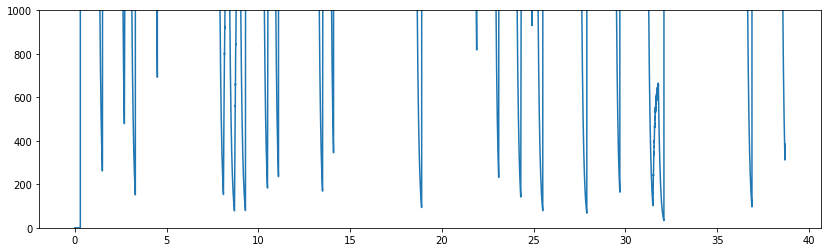

In [141]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), base_meg, label="meg")
plt.ylim(0, 1000)

In [148]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    
    rec_trans_nd = nengo.Node(lambda t, x: x * rec_w, size_in=n_neurons, size_out=n_neurons)
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts,
                         neuron_type=nengo.LIF())
    nengo.Connection(ens.neurons, rec_trans_nd, synapse=rec_synapse)
    nengo.Connection(rec_trans_nd, ens.neurons, synapse=None)

    nengo.Connection(in_nd, ens, synapse=None)

    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                                                
Simulating finished in 0:00:17.                                                                              


In [149]:
rec_meg = meg_from_spikes(sim.data[p_spikes])

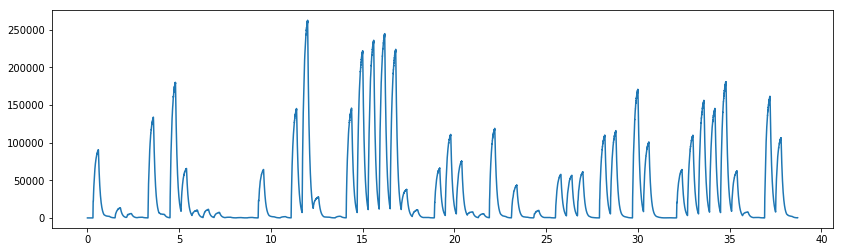

In [150]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), rec_meg, label="meg")

In [162]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    
    rec_trans_nd = nengo.Node(lambda t, x: x * norm_rec_w, size_in=n_neurons, size_out=n_neurons)
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts,
                         neuron_type=nengo.LIF())
    nengo.Connection(ens.neurons, rec_trans_nd, synapse=rec_synapse)
    nengo.Connection(rec_trans_nd, ens.neurons, synapse=None)

    nengo.Connection(in_nd, ens, synapse=None)

    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                                                
Simulating finished in 0:00:18.                                                                              


In [163]:
norm_rec_meg = meg_from_spikes(sim.data[p_spikes])

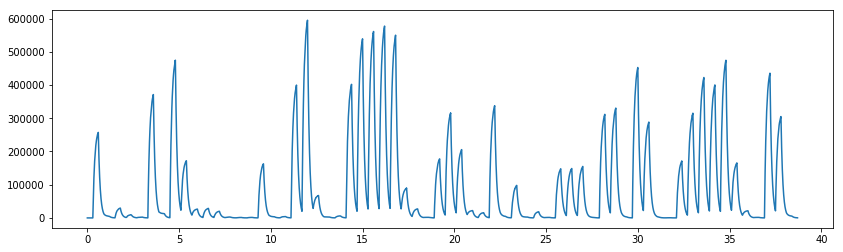

In [164]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), norm_rec_meg, label="meg")

In [165]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = base_meg[obj.slc] - norm_rec_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

diff_df = pd.concat(df_list)

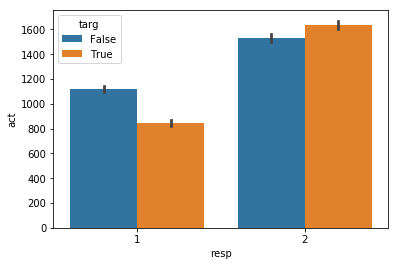

In [166]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=diff_df)

In [167]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = rec_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

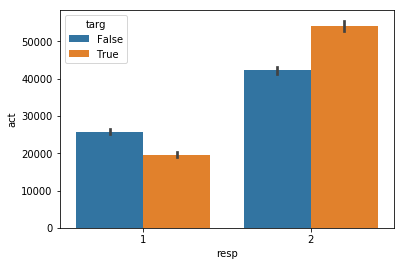

In [168]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

In [169]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = norm_rec_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

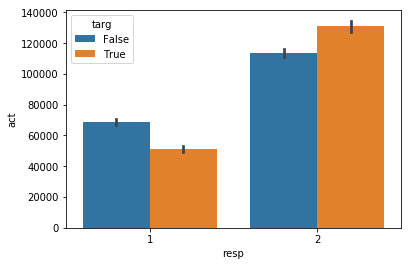

In [170]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)